# 기본 클래스 정의

In [5]:
# 기본 클래스 정의
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt

class EnsembleMethods:
    @staticmethod
    def hard_voting(predictions):
        return np.round(np.mean([np.round(pred) for pred in predictions.values()], axis=0))

    @staticmethod
    def soft_voting(predictions):
        return np.mean(list(predictions.values()), axis=0)

    @staticmethod
    def stacking(X_train, y_train, X_val, base_models, meta_model):
        # 기본 모델들의 예측값 생성
        base_predictions = np.column_stack([model.predict(X_train) for model in base_models])
        
        # 메타 모델 학습
        meta_model.fit(base_predictions, y_train)
        
        # 검증 데이터에 대한 기본 모델들의 예측값 생성
        val_base_predictions = np.column_stack([model.predict(X_val) for model in base_models])
        
        # 최종 예측
        return meta_model.predict(val_base_predictions)

# 데이터 및 모델 로드

**Hard, Soft Voting 필요한 것: 각 모델의 예측값 (CSV 파일)**

**Stacking 필요한 것: 원본 특성(features), 타겟(target), 학습된 모델(joblib 파일)**

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

X = train_data.drop('deposit', axis=1) 
y = train_data['deposit']
X_test = test_data.drop('deposit', axis=1, errors='ignore')
test_ids = test_data['index']

In [7]:
# 데이터 분할: train 데이터를 train/validation으로 나눕니다.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def load_model(file_path):
    return joblib.load(file_path)

# 각 모델에 대해 검증 데이터를 사용한 예측값을 생성
xgb_model = load_model('models/XGB_pure_time_10220009_.joblib')
lgbm_model = load_model('models/LGBM_pure_time_10220009_.joblib')
catboost_model = load_model('models/Catboost_pure_time_10220010_.joblib')

# 각 모델의 예측값 생성 (X_val을 사용)
xgb_pred = xgb_model.predict(X_val)
lgbm_pred = lgbm_model.predict(X_val)
catboost_pred = catboost_model.predict(X_val)

xgb_mae = mean_absolute_error(y_val, xgb_pred)
lgbm_mae = mean_absolute_error(y_val, lgbm_pred)
catboost_mae = mean_absolute_error(y_val, catboost_pred)

# 앙상블을 위한 예측값 딕셔너리
val_predictions = {
    'XGB': xgb_pred,
    'LGBM': lgbm_pred,
    'Catboost': catboost_pred
}

In [8]:
# Hard Voting
hard_voting_result = EnsembleMethods.hard_voting(val_predictions)
hard_voting_mae = mean_absolute_error(y_val, hard_voting_result)

# Soft Voting
soft_voting_result = EnsembleMethods.soft_voting(val_predictions)
soft_voting_mae = mean_absolute_error(y_val, soft_voting_result)

# Stacking
base_models = [xgb_model, lgbm_model, catboost_model]
meta_model = LinearRegression()
stacking_result = EnsembleMethods.stacking(X_train, y_train, X_val, base_models, meta_model)
stacking_mae = mean_absolute_error(y_val, stacking_result)

In [9]:
# 결과 출력
print(f"XGBoost MAE: {xgb_mae}")
print(f"LightGBM MAE: {lgbm_mae}")
print(f"CatBoost MAE: {catboost_mae}")
print(f"Hard Voting MAE: {hard_voting_mae}")
print(f"Soft Voting MAE: {soft_voting_mae}")
print(f"Stacking MAE: {stacking_mae}")

XGBoost MAE: 4400.089291207494
LightGBM MAE: 5590.961296405514
CatBoost MAE: 4570.854669729378
Hard Voting MAE: 4626.123990273313
Soft Voting MAE: 4626.1238868149585
Stacking MAE: 4331.411744360109


In [10]:
# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'Hard Voting', 'Soft Voting', 'Stacking'],
    'MAE': [xgb_mae, lgbm_mae, catboost_mae, hard_voting_mae, soft_voting_mae, stacking_mae]
})

In [11]:
# MAE 기준으로 정렬
results_df = results_df.sort_values('MAE')

print("\nSorted Results:")
print(results_df)


Sorted Results:
         Model          MAE
5     Stacking  4331.411744
0      XGBoost  4400.089291
2     CatBoost  4570.854670
4  Soft Voting  4626.123887
3  Hard Voting  4626.123990
1     LightGBM  5590.961296


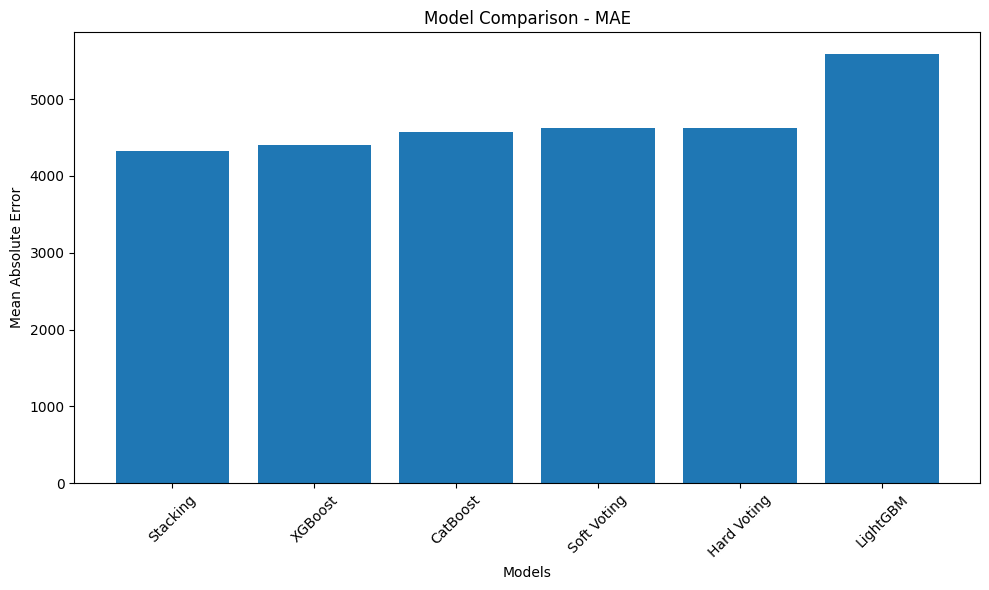

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['MAE'])
plt.title('Model Comparison - MAE')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# 테스트 데이터에 대한 예측 수행
xgb_test_pred = xgb_model.predict(X_test)
lgbm_test_pred = lgbm_model.predict(X_test)
catboost_test_pred = catboost_model.predict(X_test)

# 앙상블을 위한 테스트 예측값 딕셔너리
test_predictions = {
    'XGB': xgb_test_pred,
    'LGBM': lgbm_test_pred,
    'Catboost': catboost_test_pred
}

# Soft Voting으로 최종 예측
# final_predictions = EnsembleMethods.stacking(test_predictions)
  
# Hard Voting으로 최종 예측
# final_predictions = EnsembleMethods.hard_voting(test_predictions)

# Stacking으로 최종 예측
final_predictions = EnsembleMethods.stacking(X_train, y_train, X_test, base_models, meta_model)

# 결과를 DataFrame으로 변환
submission_df = pd.DataFrame({
    'index': test_ids,
    'deposit': final_predictions
})

# CSV 파일로 저장
submission_df.to_csv('submission.csv', index=False)
print("제출 파일이 'submission.csv'로 생성되었습니다.")

제출 파일이 'submission.csv'로 생성되었습니다.
